In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import json
import csv
import os
import string
import collections
import string
import matplotlib.pyplot as plt
import time
import seaborn as sns

from scipy.stats import zscore
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, normalize
from scipy.sparse import hstack

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adadelta,Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [5]:
business = pd.read_csv("/home/kai/yelp_dataset/business.csv", sep='delimiter', header=None)

/home/kai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
review_all = pd.read_csv("/home/kai/yelp_dataset/review.csv", sep='delimiter', header=None)

/home/kai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


ParserError: Expected 1 fields in line 6530499, saw 2. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.

In [1]:
outfile = open('/home/kai/yelp_dataset/review.csv', 'a')
sfile = csv.writer(outfile, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars','text'])

with open('/home/kai/yelp_new_datast/yelp_academic_dataset_review.json', encoding='utf-8') as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['stars'], (row['text'].encode('utf-8'))])
outfile.close()

NameError: name 'csv' is not defined

In [35]:
df_review_agg = review_all.groupby('business_id')['text'].sum()
df_merged_reviews = pd.DataFrame({'business_id':df_review_agg.index, 
                          'all_reviews':df_review_agg.values})
df_merged_reviews.head()

,business_id,all_reviews
0,--6MefnULPED_I942VcFNA,This is one of my top 3 places to get BBQ pork...
1,--7zmmkVg-IMGaXbuVd0SQ,Nice small place and the bartender was super f...
2,--8LPVSo5i0Oo61X01sV9A,Dr. Purcell is good and thorough. Their office...
3,--9QQLMTbFzLJ_oT-ON3Xw,Went to this location to get a quick trim . As...
4,--9e1ONYQuAa-CB_Rrw7Tw,As part of a birthday celebration weekend for ...


In [36]:
df_businesses = pd.read_json('/home/kai/yelp_new_datast/yelp_academic_dataset_business.json',
                             lines=True)
df_businesses.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [37]:
# Filter business review count and stars
df_businesses = df_businesses[['business_id', 'review_count', 'stars']]

# Merge dataframes
df_merged_reviews = pd.merge(df_merged_reviews, df_businesses, on='business_id')

# Filter all businesses with less than 20 reviews
df_merged_reviews = df_merged_reviews[df_merged_reviews['review_count'] >= 20]

In [40]:
df_ = df_merged_reviews.drop(['review_count'], axis=1)
df_.head()

,business_id,all_reviews,stars
2,JJjWvAyiPSIoS2qGGLjxHg,This was a super cool experience! Unlike anyth...,3.0
10,uIbZjRRqR1OR-t2NBCa1Wg,I wanted something quick due to being too lazy...,2.0


In [31]:
print(business.describe())
print(business.info())
print("\n")
print(review_all.describe())
print(review_all.info())

            latitude      longitude          stars   review_count  \
count  174566.000000  174566.000000  174567.000000  174567.000000   
mean       38.627312     -92.679009       3.632196      30.137059   
std         5.389012      26.240079       1.003739      98.208174   
min       -36.086009    -142.466650       1.000000       3.000000   
25%        33.631550    -112.125879       3.000000       4.000000   
50%        36.144257     -89.410128       3.500000       8.000000   
75%        43.606181     -79.657609       4.500000      23.000000   
max        89.999314     115.086769       5.000000    7361.000000   

             is_open  
count  174567.000000  
mean        0.840376  
std         0.366258  
min         0.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174567 entries, 0 to 174566
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------     

In [3]:
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [4]:
review_all.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [4]:
a = business[business['categories'].str.contains('Restaurant') == True]
rev = review_all[review_all.business_id.isin(a['business_id']) == True]

NameError: name 'business' is not defined

In [5]:
rev_samp = rev.sample(n = 350000, random_state=42)
train = rev_samp[0:280000]
test = rev_samp[280000:]

NameError: name 'rev' is not defined

In [7]:
train.shape, test.shape

((280000, 9), (70000, 9))

,text,stars
2760442,Second time here.... first time had the pulled...,5
3014452,Great place. Like their sauce and lunch specia...,5
2876979,So goooooooood and so simple! I love their pel...,5
469097,We stopped in for a late lunch on a Tuesday af...,3
4971248,A great option to try hakka chinese since its ...,4


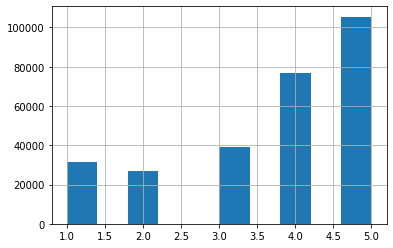

In [8]:
train = train[['text', 'stars']]
train['stars'].hist();train.head()

In [9]:
train = pd.get_dummies(train, columns=['stars'])
train.head()

,text,stars_1,stars_2,stars_3,stars_4,stars_5
2760442,Second time here.... first time had the pulled...,0,0,0,0,1
3014452,Great place. Like their sauce and lunch specia...,0,0,0,0,1
2876979,So goooooooood and so simple! I love their pel...,0,0,0,0,1
469097,We stopped in for a late lunch on a Tuesday af...,0,0,1,0,0
4971248,A great option to try hakka chinese since its ...,0,0,0,1,0


In [10]:
test = test[['text', 'stars']]
test = pd.get_dummies(test, columns=['stars'])
train.shape, test.shape

((280000, 6), (70000, 6))

In [11]:
train_samp = train.sample(frac = .1, random_state=42)
test_samp = test.sample(frac = .1, random_state=42)
train_samp.shape, test_samp.shape

((28000, 6), (7000, 6))

In [12]:
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

In [13]:
class NBFeatures(BaseEstimator):
    def __init__(self, alpha):
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x,1,y)/self.pr(x,0,y)))
        return self
    
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb
            

In [14]:
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [15]:
import sklearn
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
scores = []
preds = np.zeros((len(test_samp), len(class_names)))
for i, class_names in enumerate(class_names):
    train_target = train_samp[class_names]
    cv_score = np.mean(sklearn.model_selection.cross_val_score(estimator = p, X = train_samp['text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_names, cv_score))
    p.fit(train_samp['text'].values, train_target)
    preds[:,i] = p.predict_proba(test_samp['text'].values)[:,1]
    

CV score for class stars_1 is 0.9282499819604656
CV score for class stars_2 is 0.90339283521352
CV score for class stars_3 is 0.8591786654537303
CV score for class stars_4 is 0.7321071676830603
CV score for class stars_5 is 0.8044644727087923


In [16]:
train['text'][4971248]

'A great option to try hakka chinese since its halal! We had cantonese chow mein, chicken 88 and spicy fish with vegetable stir fry rice and that was all enough for four people to eat! Beware, their portion sizes are huge and that will be your only complaint! For those that like mild spices though, you will have to ask them to keep it mild!'

In [17]:
embed_size = 200
max_features = 20000
maxlen = 200

embedding_file = '/home/kai/yelp_dataset/glove.twitter.27B.200d.txt'

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [18]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
y = train_samp[class_names].values

In [19]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['text'].values)
X_test = tokenizer.texts_to_sequences(test_samp['text'].values)
x_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(X_test, maxlen=maxlen)

In [20]:
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words,embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features:
        break
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [21]:
len(missed)

2147

In [22]:
missed[0:10]

["it's", "don't", "i'm", "i've", "didn't", '5', '2', '3', "wasn't", '4']

In [23]:
missed[1000:1010]

["lobby's",
 "capo's",
 "'fast",
 'gratuities',
 "owners'",
 'brasseurs',
 'mittagszeit',
 "soup'",
 "pauly's",
 "flo's"]

In [1]:
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation='sigmoid')(conc)


model = Model(inputs = inp, outputs = outp)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)
checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='weights.hdf5')
model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])

NameError: name 'Input' is not defined

In [43]:
model.fit(x_train, y, batch_size=512,epochs=20, validation_split=.1,callbacks=[earlystop,checkpoint])

Epoch 1/20
50/50 [==============================] - 52s 959ms/step - loss: 0.1564 - accuracy: 0.3676 - val_loss: 0.1451 - val_accuracy: 0.3868
Epoch 2/20
50/50 [==============================] - 46s 929ms/step - loss: 0.1344 - accuracy: 0.4326 - val_loss: 0.1239 - val_accuracy: 0.4957
Epoch 3/20
19/50 [==========>...................] - ETA: 34s - loss: 0.1239 - accuracy: 0.4972

In [26]:
y_test = model.predict([x_test], batch_size=1024, verbose=1)

7/7 [==============================] - 5s 629ms/step


In [27]:
model.evaluate(x_test, test_samp[class_names].values, verbose=1,batch_size=1024)

7/7 [==============================] - 4s 648ms/step - loss: 0.3359 - accuracy: 0.6111


[0.33594608306884766, 0.6111428737640381]

In [28]:
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.66      0.73      0.69       771
           1       0.43      0.45      0.44       687
           2       0.50      0.47      0.48      1020
           3       0.53      0.53      0.53      1906
           4       0.75      0.73      0.74      2616

    accuracy                           0.61      7000
   macro avg       0.57      0.58      0.58      7000
weighted avg       0.61      0.61      0.61      7000



In [29]:
model.save('nn_model.h5')